In [34]:
import os
import warnings

warnings.filterwarnings('ignore')
os.environ['TOKENIZERS_PARALLELISM'] = 'true'

In [35]:
import numpy as np

import matplotlib.pyplot as plt

from lambeq import BobcatParser
from lambeq import AtomicType, IQPAnsatz, remove_cups
from lambeq import TketModel
from lambeq import QuantumTrainer, SPSAOptimizer
from lambeq import Dataset

from discopy import grammar
from discopy import Dim

from pytket.extensions.qiskit import AerBackend
from pytket.circuit.display import render_circuit_jupyter


In [36]:
BATCH_SIZE = 50
EPOCHS = 10
SEED = 2

In [37]:
#Input data MC1

def read_data(filename):
    labels, sentences = [], []
    with open(filename) as f:
        for line in f:
            #sentences are split by , in our data set
            end_sentence = line.split(",")
            t = int(end_sentence[2])
            labels.append([t, 1-t])
            #there are two sentences per associated label
            #we need to make sure they are both used
            sentences.append(end_sentence[0])
            sentences.append(end_sentence[1])
    return labels, sentences

In [38]:
#Testing
print(read_data('MC1.TXT'))

([[1, 0], [1, 0], [0, 1], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [0, 1], [0, 1], [0, 1], [0, 1], [1, 0], [0, 1], [1, 0], [0, 1], [0, 1], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [0, 1], [1, 0], [1, 0], [1, 0], [1, 0], [0, 1], [1, 0], [0, 1], [0, 1], [1, 0], [1, 0], [1, 0], [1, 0], [0, 1], [1, 0], [1, 0], [0, 1], [1, 0], [0, 1], [0, 1], [1, 0], [1, 0], [0, 1], [0, 1], [0, 1], [1, 0], [0, 1], [1, 0], [1, 0], [0, 1], [1, 0], [1, 0], [0, 1], [0, 1], [0, 1], [1, 0], [0, 1], [0, 1], [1, 0], [0, 1], [1, 0], [0, 1], [0, 1], [0, 1], [1, 0], [0, 1], [0, 1], [1, 0], [1, 0], [0, 1], [1, 0], [1, 0], [0, 1], [1, 0], [0, 1], [0, 1], [0, 1], [1, 0], [1, 0], [0, 1], [1, 0], [1, 0], [1, 0], [0, 1], [0, 1], [0, 1], [1, 0], [1, 0], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [1, 0], [1, 0]], ['cook creates complicated dish', ' experienced chef prepares complicated dish', 'skilful programmer creates code', ' devoted hacker writes code', 'skilful cook creates meal', ' devoted hacker crea

In [39]:
#we will use 15% of the data as a training set
labels, data = read_data('MC1.TXT')
train_labels, train_data = labels[0:15] , data[0:15]
test_labels, test_data = labels[15:100] , data[15:100]

In [40]:
#Parser
parser = BobcatParser(root_cats=('NP', 'N'), verbose='text')
train_diagrams = parser.sentences2diagrams(train_data, suppress_exceptions=True)
test_diagrams = parser.sentences2diagrams(test_data, suppress_exceptions=True)


Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.


In [41]:
train_diagrams = [
    diagram.normal_form()
    for diagram in train_diagrams if diagram is not None]
test_diagrams = [
    diagram.normal_form()
    for diagram in test_diagrams if diagram is not None]

train_labels = [
    label for (diagram, label)
    in zip(train_diagrams, train_labels)
    if diagram is not None]
test_labels = [
    label for (diagram, label)
    in zip(test_diagrams, test_labels)
    if diagram is not None]

In [42]:
#Circuits
ansatz = IQPAnsatz({AtomicType.NOUN: 1, AtomicType.SENTENCE: 0},
                   n_layers=1, n_single_qubit_params=3)

train_circuits = [ansatz(remove_cups(diagram)) for diagram in train_diagrams]
test_circuits =  [ansatz(remove_cups(diagram))  for diagram in test_diagrams]


In [69]:
#Testing

#print(train_circuits[1])
#print(train_circuits[1])
print(train_data)
#training data binary association: 1 = code, 0 = chef
training_tags = [0,0,1,1,0,1,1,1,1,1,1,1,0,0,1]


['cook creates complicated dish', ' experienced chef prepares complicated dish', 'skilful programmer creates code', ' devoted hacker writes code', 'skilful cook creates meal', ' devoted hacker creates complicated code', 'hacker writes code', ' skilful hacker creates code', 'devoted hacker writes code', ' hacker writes complicated code', 'skilful programmer creates advanced code', ' skilful hacker writes complicated code', 'experienced cook prepares meal', ' experienced chef prepares meal', 'devoted programmer creates advanced code']
1


In [46]:
#Model
all_circuits = train_circuits + test_circuits

backend = AerBackend()
backend_config = {
    'backend': backend,
    'compilation': backend.default_compilation_pass(2),
    'shots': 8192
}

'''
#Standart model
model = TketModel.from_diagrams(all_circuits, backend_config=backend_config)
'''

class MyCustomModel(PytorchModel):
    def __init__(self):
        super().__init__()
        self.net = torch.nn.Linear(2, 2)

    def forward(self, input):
        """define a custom forward pass here"""
        preds = self.get_diagram_output(input)
        preds = self.net(preds)
        return preds

custom_model = MyCustomModel.from_diagrams(all_circuits)

In [47]:
#Loss & eval metrics
loss = lambda y_hat, y: -np.sum(y * np.log(y_hat)) / len(y)  # binary cross-entropy loss
acc = lambda y_hat, y: np.sum(np.round(y_hat) == y) / len(y) / 2  # half due to double-counting
eval_metrics = {"acc": acc}


In [48]:
#Trainer
''' 
#Standart model
trainer = QuantumTrainer(
    model,
    loss_function=loss,
    epochs=EPOCHS,
    optimizer=SPSAOptimizer,
    optim_hyperparams={'a': 0.05, 'c': 0.06, 'A':0.01*EPOCHS},
    evaluate_functions=eval_metrics,
    evaluate_on_train=True,
    verbose = 'text',
    seed=0
)
'''
custom_model_trainer = PytorchTrainer(
        model=custom_model,
        loss_function=torch.nn.BCEWithLogitsLoss(),
        optimizer=torch.optim.AdamW,
        learning_rate=LEARNING_RATE,
        epochs=EPOCHS,
        evaluate_functions=eval_metrics,
        evaluate_on_train=True,
        verbose='text',
        seed=SEED)
custom_model_trainer.fit(train_dataset, val_dataset, logging_step=5)

In [49]:
#Create dataset
train_dataset = Dataset(
            train_circuits,
            train_labels,
            batch_size=BATCH_SIZE)

test_dataset = Dataset(test_circuits, test_labels, shuffle=False)

In [50]:
#Train model
trainer.fit(train_dataset, test_dataset, evaluation_step=1, logging_step=100)

Epoch 1:    train/loss: 4.1082   valid/loss: 3.8586   train/acc: 0.3000   valid/acc: 0.5176
Epoch 100:  train/loss: 0.4479   valid/loss: 1.5248   train/acc: 0.8667   valid/acc: 0.5235

Training completed!


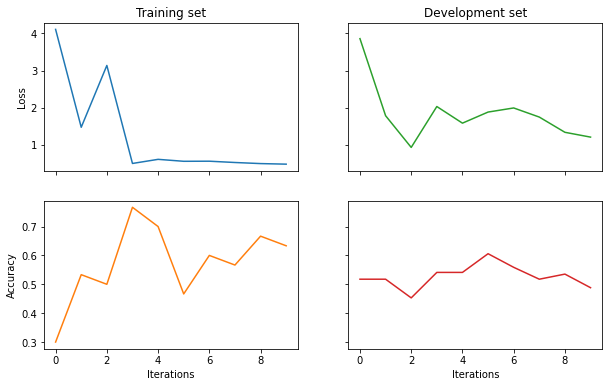

In [51]:
#Printing train model
fig, ((ax_tl, ax_tr), (ax_bl, ax_br)) = plt.subplots(2, 2, sharex=True, sharey='row', figsize=(10, 6))
ax_tl.set_title('Training set')
ax_tr.set_title('Development set')
ax_bl.set_xlabel('Iterations')
ax_br.set_xlabel('Iterations')
ax_bl.set_ylabel('Accuracy')
ax_tl.set_ylabel('Loss')

colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
ax_tl.plot(trainer.train_epoch_costs[::10], color=next(colours))
ax_bl.plot(trainer.train_results['acc'][::10], color=next(colours))
ax_tr.plot(trainer.val_costs[::10], color=next(colours))
ax_br.plot(trainer.val_results['acc'][::10], color=next(colours))